In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import numpy as np
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
import seaborn as sns
from matplotlib.gridspec import GridSpec
import os

In [2]:
current_working_directory = os.getcwd()
lab_directory = os.path.dirname(current_working_directory)
paper_dir = os.path.join(lab_directory, "paper")
folder_figures = os.path.join(paper_dir, "plots")
folder_tables = os.path.join(paper_dir, "tabelas")

columns_Y = [
    "UpwardUsedSecondaryReserveEnergy",
    "DownwardUsedSecondaryReserveEnergy",
]

data_folder = os.path.join(lab_directory, "data")
training_dataset_path = os.path.join(data_folder, "raw", "dados_2014-2022.csv")

training_dataset = pd.read_csv(training_dataset_path, index_col=0)

training_dataset["datetime"] = pd.to_datetime(training_dataset["datetime"])
dataset = training_dataset.set_index("datetime")

In [3]:
pairs_dict = {
    "Upward Allocation": {
        "test": "UpwardUsedSecondaryReserveEnergy",
        "benchmark": "SecondaryReserveAllocationAUpward",
        "prediction": "UpwardPrediction",
    },
    "Downward Allocation": {
        "test": "DownwardUsedSecondaryReserveEnergy",
        "benchmark": "SecondaryReserveAllocationADownward",
        "prediction": "DownwardPrediction",
    },
}

In [4]:
trans_dict = {
    "Upward Allocation": "Alocação para cima",
    "Downward Allocation": "Alocação para baixo",
}

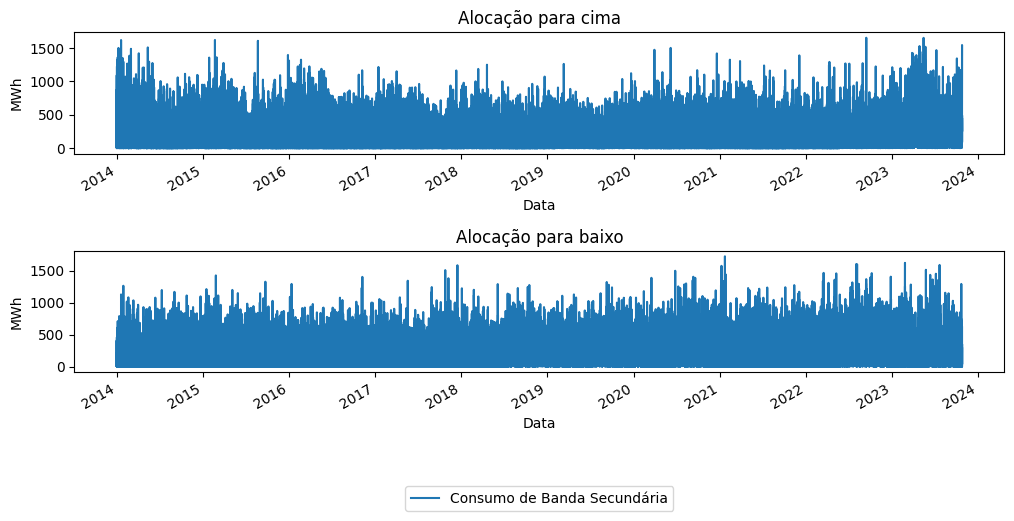

In [5]:
nrows = 2
ncols = 1

count = 0
fig, axis = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 5))

for alloc, col_names in pairs_dict.items():
    test_col = col_names["test"]
    benchmark_col = col_names["benchmark"]

    # Adjust the vertical spacing here
    plt.subplots_adjust(hspace=0.8)
    ax = axis.flatten()[count]

    # Check target distribution
    dataset[test_col].plot(ax=ax, label="Consumo de Banda Secundária")
    # dataset[benchmark_col].plot(ax=ax,label="Alocação de Banda Secundária")
    alloc_trans = trans_dict[alloc]

    ax.set_title(alloc_trans)
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    # Set x-axis label to "Ano"
    ax.set_xlabel("Data")
    # Set y-axis label to "MWh"
    ax.set_ylabel("MWh")

    count += 1

plt.legend(bbox_to_anchor=(0.5, -1.2), loc="lower center")

# plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()
fig.savefig(
    os.path.join(folder_figures, "consumo_originais.png"), bbox_inches="tight"
)

In [6]:
pair_label = {
    "UpwardUsedSecondaryReserveEnergy": "Consumo de Reserva Secundária a Subir",
    "DownwardUsedSecondaryReserveEnergy": "Consumo de Reserva Secundária a Descer",
}

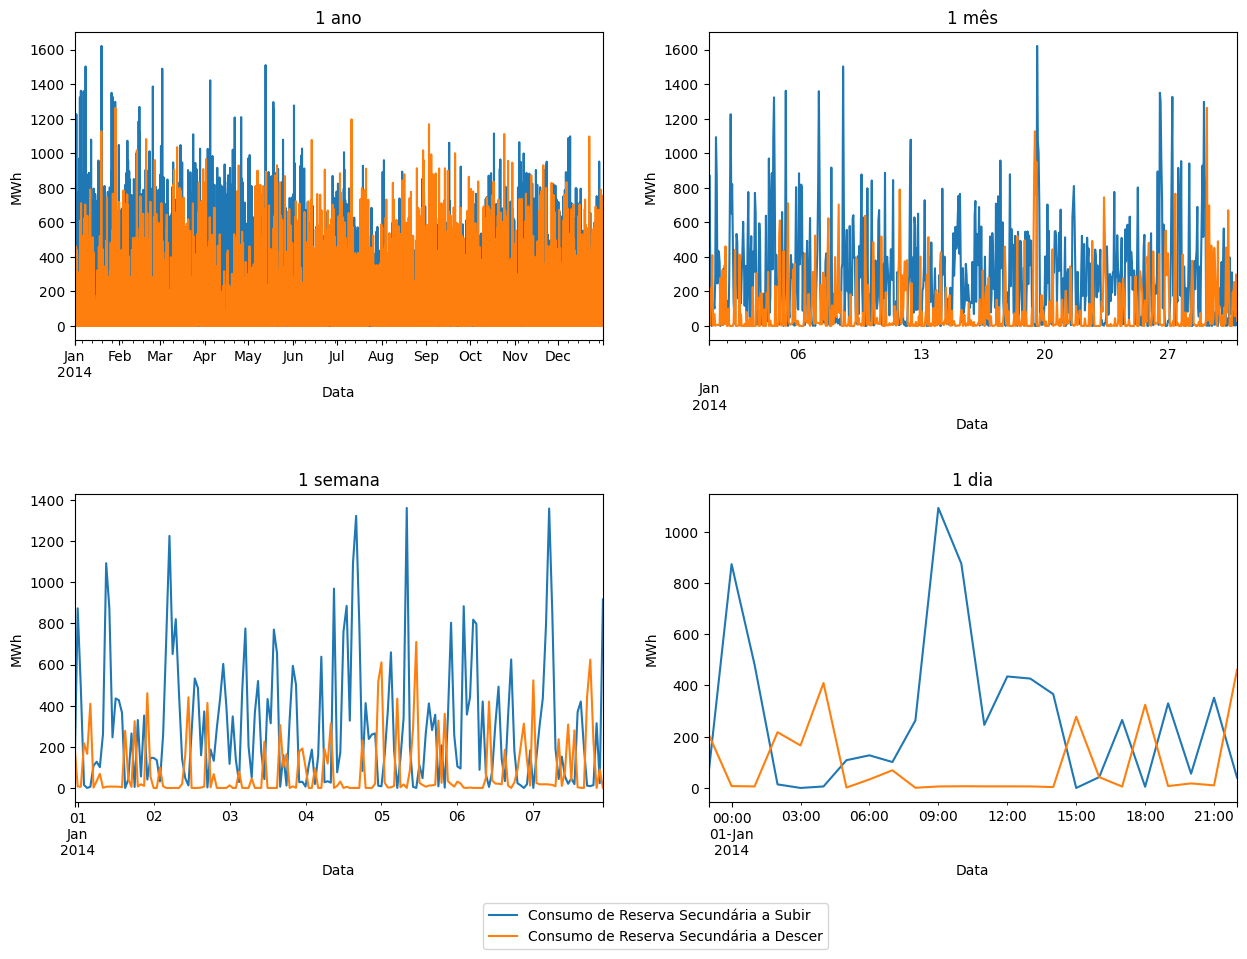

In [7]:
import matplotlib.dates as mdates

# Select relevant columns and set the datetime column as index
dataset2 = dataset  # .set_index('datetime')

# 1 year = 24*365 hours, 1 month = 24*30 hours, 1 week = 24*7 hours, 1 day = 24 hours
time_ranges = [24 * 365, 24 * 30, 24 * 7, 24]
time_ranges_names = ["1 ano", "1 mês", "1 semana", "1 dia"]

fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs = axs.flatten()

# Check target distribution
for ax, time_range, time_range_name in zip(
    axs, time_ranges, time_ranges_names
):
    for count, col in enumerate(columns_Y):
        label_name = pair_label[col]
        dataset2[col].iloc[:time_range].plot(ax=ax, label=label_name)

    ax.set_title(time_range_name)
    # ax.xaxis.set_major_locator(mdates.YearLocator())
    # ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.set_xlabel("Data")
    ax.set_ylabel("MWh")

# Adjust the vertical spacing here
plt.subplots_adjust(hspace=0.5)
plt.legend(bbox_to_anchor=(-0.1, -0.5), loc="lower center")

figure_name = "target_timeseries_windows.png"

fig.savefig(os.path.join(folder_figures, figure_name), bbox_inches="tight")

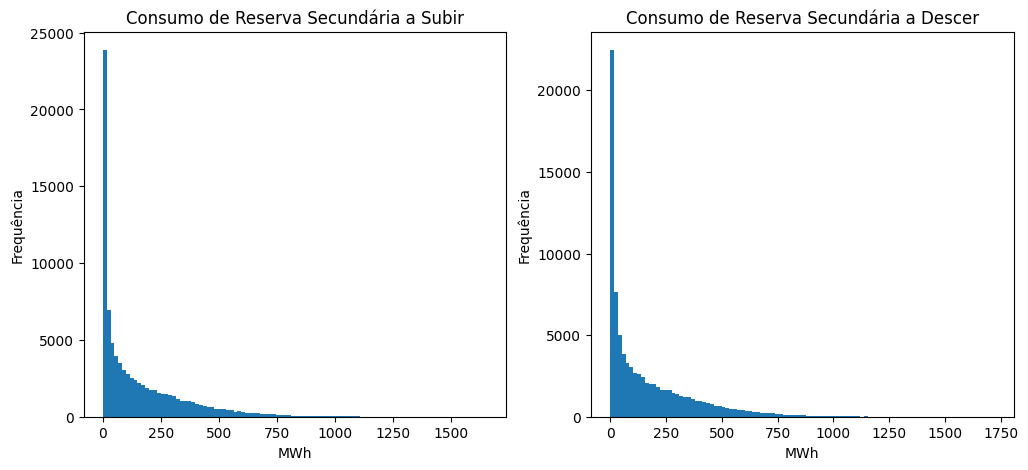

In [8]:
nrows = 1
ncols = 2
fig, axis = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 5))

# Check target distribution
for count, col in enumerate(columns_Y):
    dataset[col].plot.hist(bins=100, ax=np.array(axis).flatten()[count])
    label_name = pair_label[col]

    axis.flatten()[count].set_title(label_name)
    axis.flatten()[count].set_ylabel("Frequência")
    axis.flatten()[count].set_xlabel("MWh")

figure_name = "target_histograms.png"

plt.savefig(os.path.join(folder_figures, figure_name))

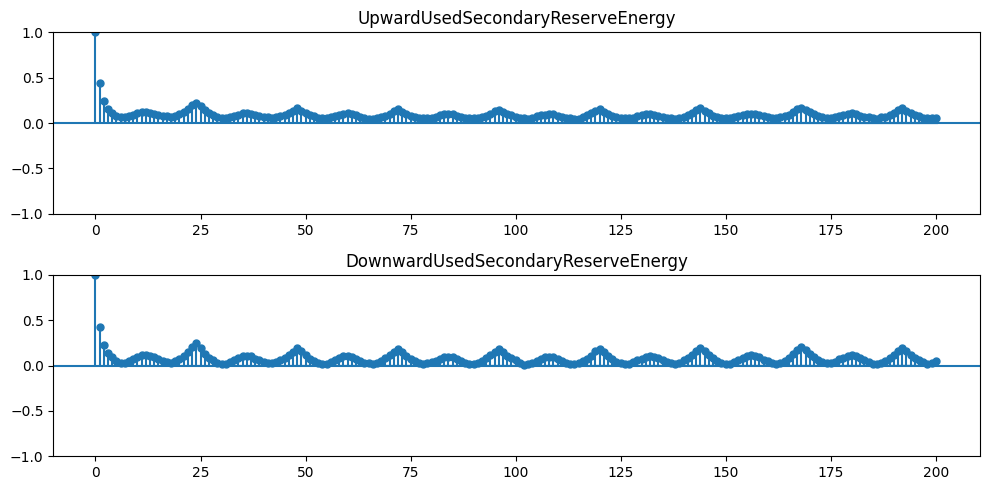

In [9]:
from statsmodels.graphics.tsaplots import plot_acf

# Select relevant columns and set the datetime column as index
dataset2 = dataset#.set_index("datetime")
lag_time = 200

fig, axs = plt.subplots(len(columns_Y), figsize=(10, 5))

for i, col in enumerate(columns_Y):
    # Calculate and plot the autocorrelation for each variable
    plot_acf(dataset2[col], lags=lag_time, ax=axs[i], title=col)

# Show the autocorrelation plots
figure_name = "autocorrelation.png"

plt.tight_layout()
plt.savefig(os.path.join(folder_figures, figure_name))

In [ ]:
from statsmodels.tsa.stattools import acf

lags_dict={}
for y_col in columns_Y:
    lags_dict[y_col]=acf(dataset2[y_col], nlags=lag_time)

lags_pd = pd.DataFrame(lags_dict)
lags_order = []
for y_col in columns_Y:
    lags_col_order = lags_pd[[y_col]].sort_values(by=y_col,ascending=False)[:10]
    lags_col_order["horas"] = lags_col_order.index
    lags_col_order["horas"] = lags_col_order["horas"].astype(int)
    lags_col_order["rácio"]=lags_col_order[y_col]
    lags_col_order = lags_col_order.drop(columns=y_col)
    lags_col_order = lags_col_order.iloc[1:].T
    lags_col_order.loc["horas"] = lags_col_order.loc["horas"].astype(int)
    t = lags_col_order.loc["horas"]
    t = [str(int(f)) for f in t.to_list()]
    lags_col_order.loc["horas"] = t
    lags_col_order["a"] = y_col
    #lags_col_order["b"]=None
    #lags_col_order = lags_col_order.reset_index(drop=True)

    lags_order.append(lags_col_order)

lags_order = pd.concat(lags_order, ignore_index=False)
lags_order["b"] = lags_order.index
lags_order=lags_order.set_index(["a", "b"])
lags_order.index.names=[None,None]
#lags_order.columns=[None]*len(lags_order.columns)

In [11]:
lags_order

1         2        24  \
UpwardUsedSecondaryReserveEnergy   horas         1         2        24   
                                   rácio  0.438638  0.238463  0.224428   
DownwardUsedSecondaryReserveEnergy horas         1         2        24   
                                   rácio  0.428494  0.222408  0.245951   

                                                23        25       168  \
UpwardUsedSecondaryReserveEnergy   horas        23        25       168   
                                   rácio  0.194127  0.185967  0.168903   
DownwardUsedSecondaryReserveEnergy horas        23        25       168   
                                   rácio  0.201664  0.192298  0.205081   

                                               144       192        48  
UpwardUsedSecondaryReserveEnergy   horas       144       192        48  
                                   rácio  0.164519  0.162944  0.161157  
DownwardUsedSecondaryReserveEnergy horas       144       192        48  
                                   rácio  0.191427  0.196883  0.193137

In [12]:
lags_order.to_latex(
    os.path.join(folder_tables, "autocorrelation.tex"),
    header=False,
    escape=False,  # index=False,
    float_format="%.2f",
)

In [13]:
dataset.columns

Index(['SecondaryReserveAllocationAUpward',
       'SecondaryReserveAllocationADownward',
       'UpwardUsedSecondaryReserveEnergy',
       'DownwardUsedSecondaryReserveEnergy', 'WindD+1DailyForecast',
       'PhotovoltaicD+1DailyForecast', 'DemandD+1DailyForecast',
       'TotalBaseDailyOperatingSchedulePBFGeneration',
       'BaseDailyOperatingSchedulePBFSolarPV',
       'BaseDailyOperatingSchedulePBFWind',
       'BaseDailyOperatingShedulePBFTotalBalanceInterconnections'],
      dtype='object')

In [14]:
columns_Y = [
    "UpwardUsedSecondaryReserveEnergy",
    "SecondaryReserveAllocationAUpward",
    "SecondaryReserveAllocationADownward",
    "DownwardUsedSecondaryReserveEnergy",
    "WindD+1DailyForecast",
    "PhotovoltaicD+1DailyForecast",
    "DemandD+1DailyForecast",
    "TotalBaseDailyOperatingSchedulePBFGeneration",
    "BaseDailyOperatingSchedulePBFSolarPV",
    "BaseDailyOperatingSchedulePBFWind",
    "BaseDailyOperatingShedulePBFTotalBalanceInterconnections",
]

columns_X = [
    "UpwardUsedSecondaryReserveEnergy",
    "SecondaryReserveAllocationAUpward",
]

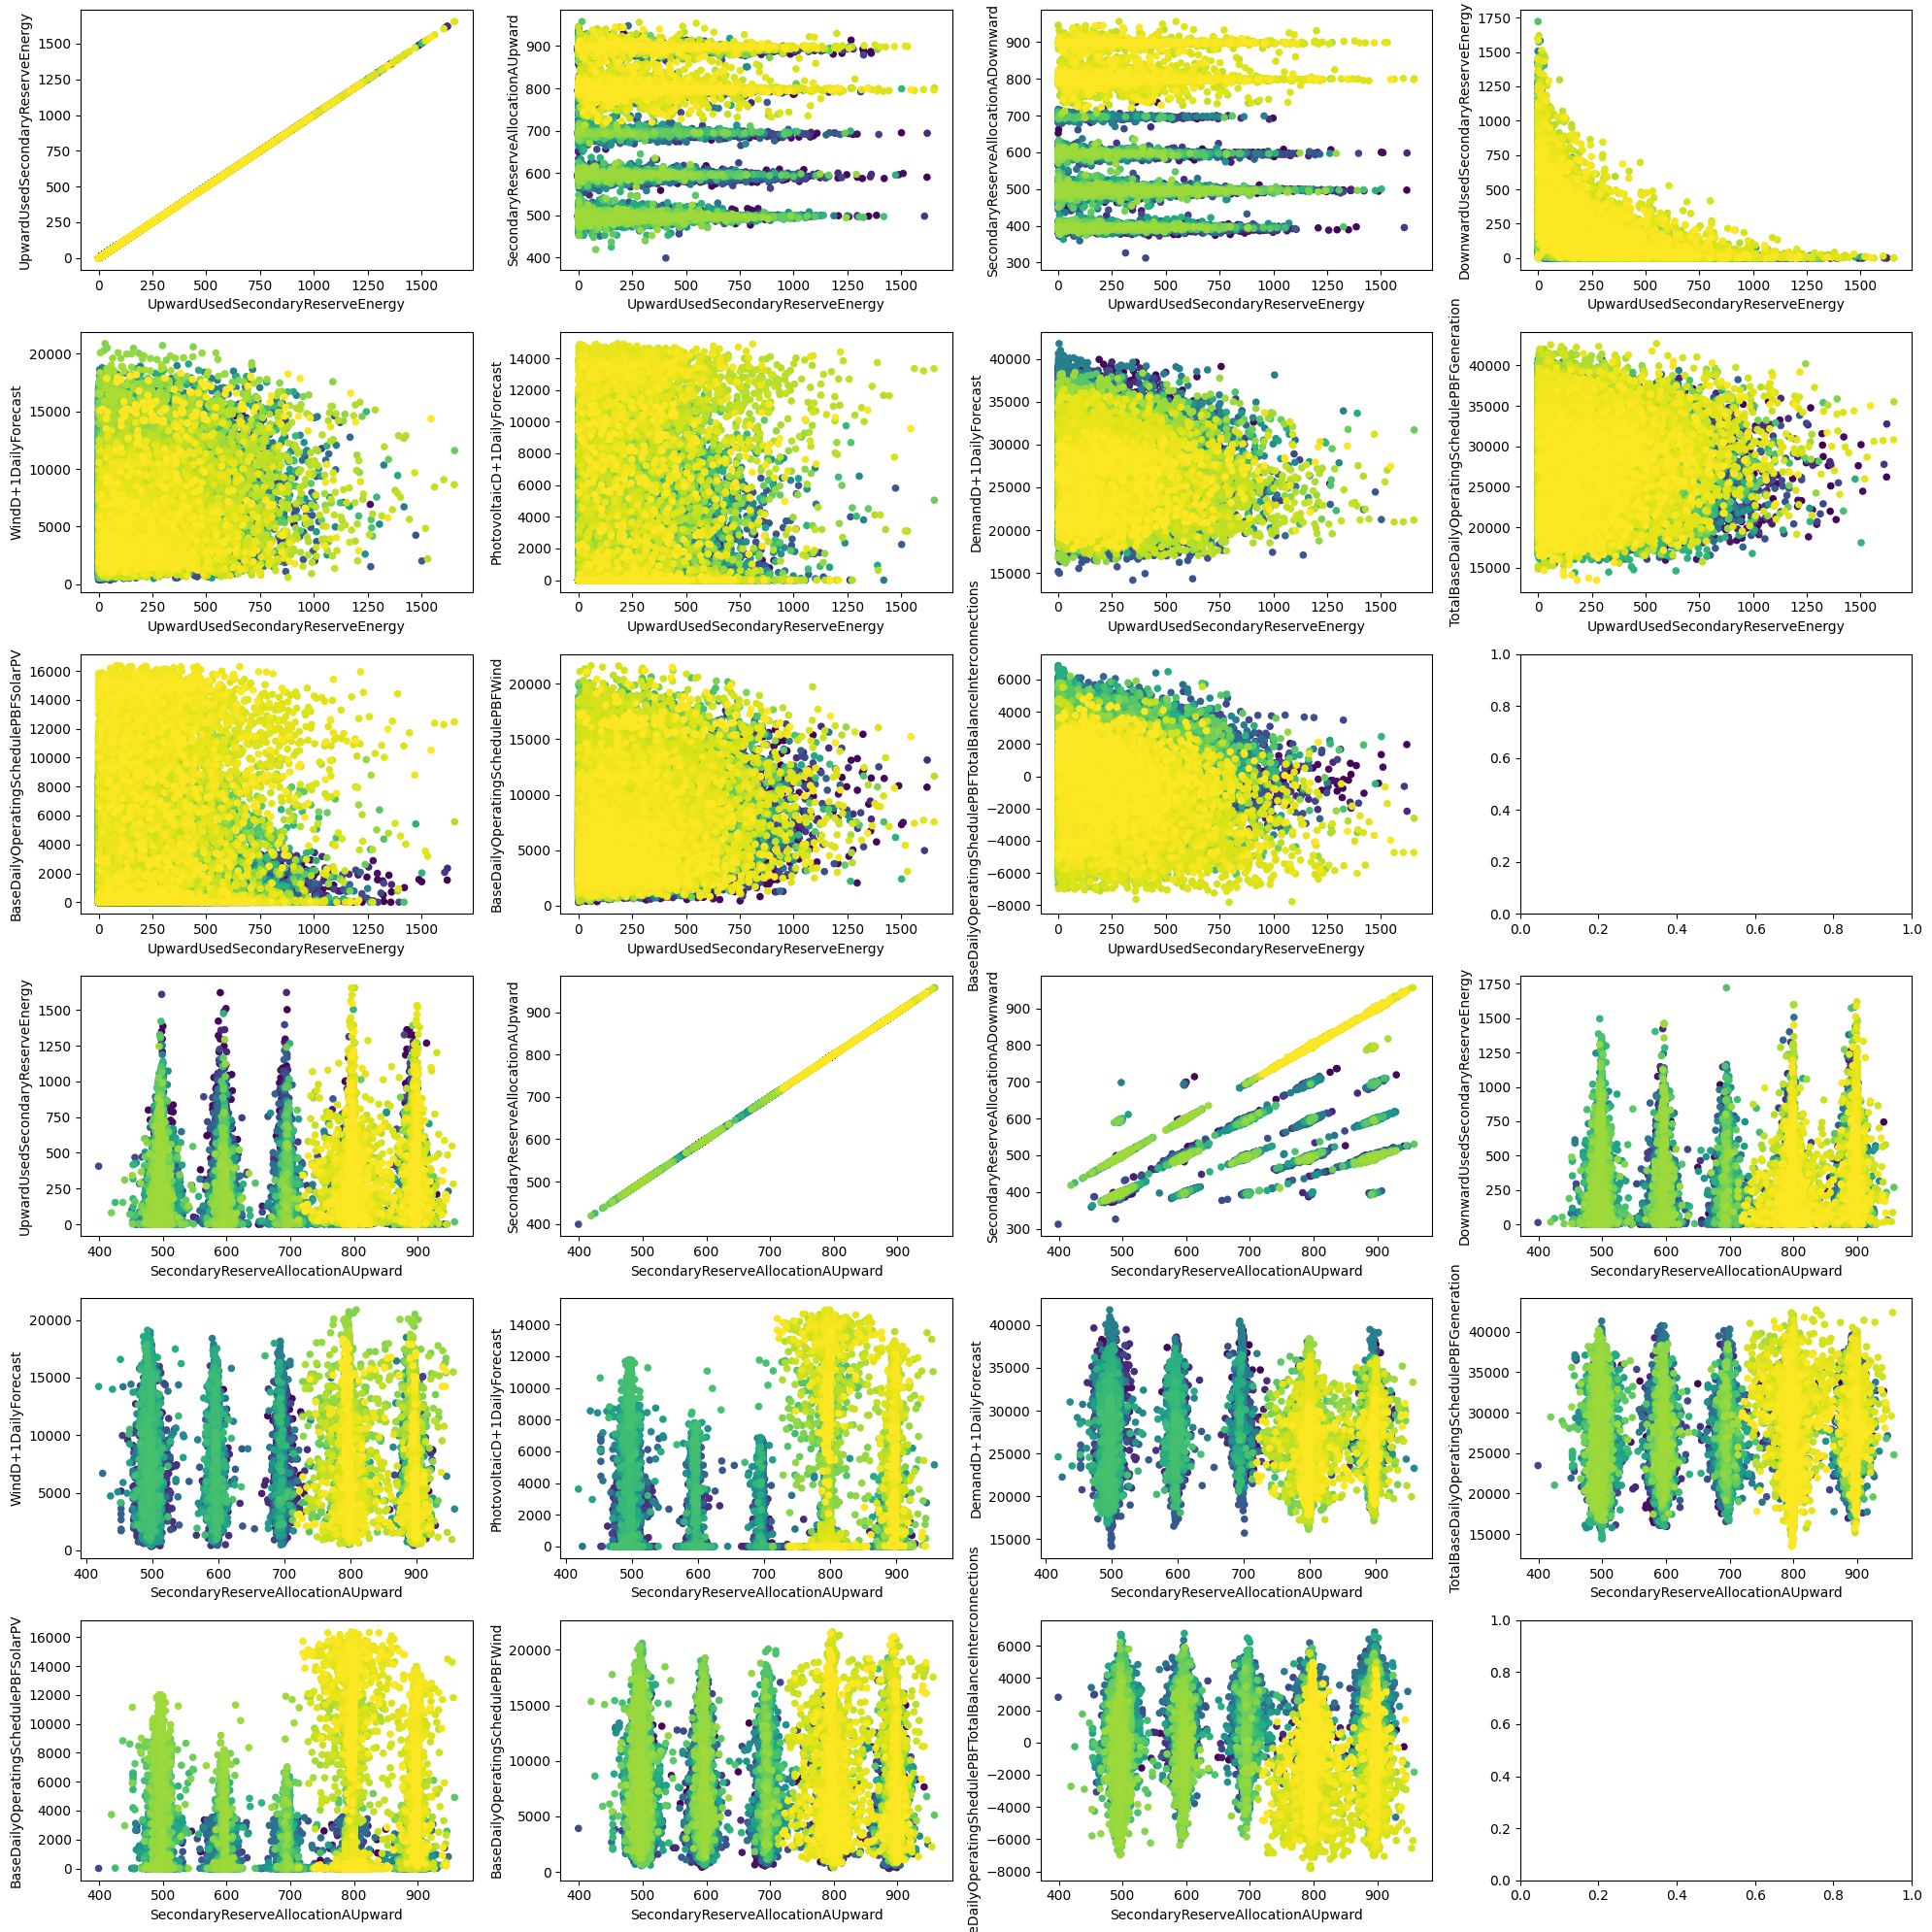

In [15]:
import math

ncols = len(columns_X)
nrows = len(columns_Y)

n_plots = ncols * nrows
sqrt_n_plots = math.ceil(math.sqrt(n_plots))

if sqrt_n_plots > 4:
    ncols = 4
else:
    ncols = sqrt_n_plots
nrows = math.ceil(n_plots / ncols)

count = 0
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 20))
count = 0
for c in range(len(columns_X)):
    for r in range(len(columns_Y)):
        ax = axes.ravel()[count]
        y_col = columns_Y[r]
        x_col = columns_X[c]

        dataset.plot.scatter(
            x_col,
            y_col,
            ax=ax,
            c=np.arange(len(dataset)),
            cmap=plt.cm.viridis,
            colorbar=False,
        )
        count += 1
        if r == 10:
            count += 1

# Adjust layout to fit subplots properly
plt.tight_layout()

# Save the figure
figure_name = "feature_correlation.png"
plt.savefig(os.path.join(folder_figures, figure_name))

# Display the figure
plt.show()

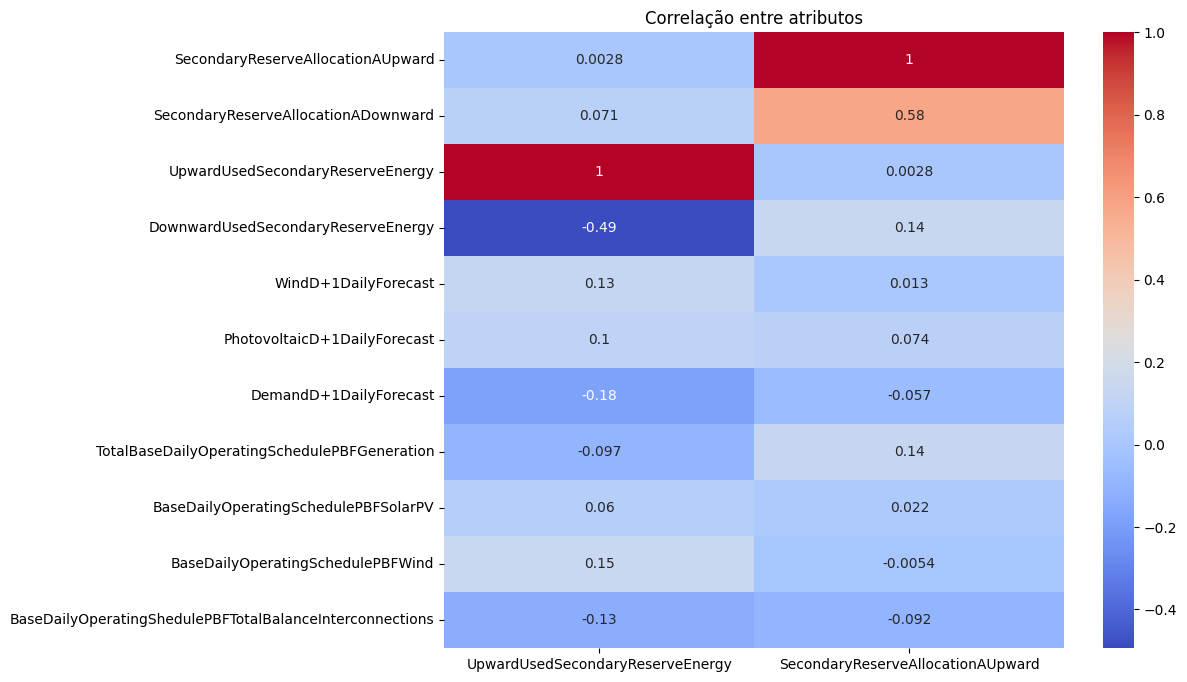

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

correlation_matrix = dataset.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix[columns_X], annot=True, cmap="coolwarm")


figure_name = "correlation_heatmap.png"
plt.title("Correlação entre atributos")

plt.savefig(os.path.join(folder_figures, figure_name), bbox_inches="tight")
plt.show()

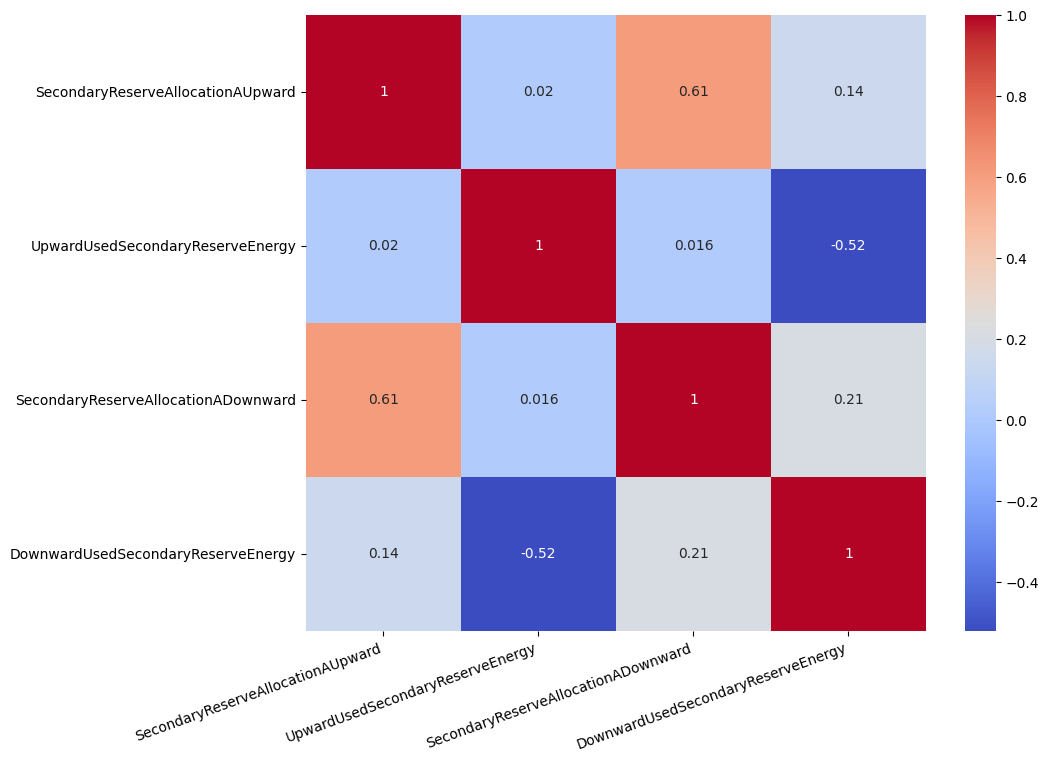

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

correlation_matrix = dataset.loc[dataset.index.year.isin([2019,2020,2021,2022])][[
    "SecondaryReserveAllocationAUpward",
            "UpwardUsedSecondaryReserveEnergy",
    "SecondaryReserveAllocationADownward",
    "DownwardUsedSecondaryReserveEnergy",
        ]].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=20, ha='right')

figure_name = "correlation_heatmap_benchmark.png"
#plt.title("Correlação entre ")

plt.savefig(os.path.join(folder_figures, figure_name), bbox_inches="tight")
plt.show()

In [ ]:
training_dataset = pd.read_csv(training_dataset_path, index_col=0)

table_training = training_dataset[
    [
        "DownwardUsedSecondaryReserveEnergy",
        "SecondaryReserveAllocationAUpward",
        "SecondaryReserveAllocationADownward",
        "UpwardUsedSecondaryReserveEnergy",
        "WindD+1DailyForecast",
        "PhotovoltaicD+1DailyForecast",
        "DemandD+1DailyForecast",
        "TotalBaseDailyOperatingSchedulePBFGeneration",
        "BaseDailyOperatingSchedulePBFSolarPV",
        "BaseDailyOperatingSchedulePBFWind",
        "BaseDailyOperatingShedulePBFTotalBalanceInterconnections",
    ]
]


media = table_training.mean().to_frame().T
media["Análise"] = "média"
desvio = table_training.std().to_frame().T
desvio["Análise"] = "desvio padrão"
minimo = table_training.min().to_frame().T
minimo["Análise"] = "min"
maximo = table_training.max().to_frame().T
maximo["Análise"] = "max"
table_training_tabela = pd.concat(
    [media, desvio, minimo, maximo], ignore_index=True
).set_index("Análise")
table_training_tabela.index.names = [None]

In [64]:
table_training_tabela = table_training_tabela.T

In [65]:
table_training_tabela

,média,desvio padrão,min,max
DownwardUsedSecondaryReserveEnergy,168.202305,199.665258,0.0,1721.4
SecondaryReserveAllocationAUpward,662.937658,150.623601,399.0,958.0
SecondaryReserveAllocationADownward,549.270530,126.668935,312.0,956.0
UpwardUsedSecondaryReserveEnergy,158.098920,191.622525,0.0,1654.8
WindD+1DailyForecast,6397.749877,3669.533785,348.0,20879.3
PhotovoltaicD+1DailyForecast,2466.066414,3543.342258,0.0,14925.3
DemandD+1DailyForecast,27357.828994,4476.459866,14170.0,41773.0
TotalBaseDailyOperatingSchedulePBFGeneration,27249.428014,4603.583482,13470.5,42707.6
BaseDailyOperatingSchedulePBFSolarPV,1798.529206,2861.849911,0.1,16358.9
BaseDailyOperatingSchedulePBFWind,6525.507714,3582.362263,308.6,21619.6


In [66]:
training_dataset_path = "/home/joao/Documentos/renewable-penetration/data/processed/dados_2014-2022_new.csv"

training_dataset = pd.read_csv(training_dataset_path, index_col=0)

table_training = training_dataset[
    [
        "DownwardUsedSecondaryReserveEnergy",
        "SecondaryReserveAllocationAUpward",
        "SecondaryReserveAllocationADownward",
        "UpwardUsedSecondaryReserveEnergy",
        "WindD+1DailyForecast",
        "PhotovoltaicD+1DailyForecast",
        "DemandD+1DailyForecast",
        "TotalBaseDailyOperatingSchedulePBFGeneration",
        "BaseDailyOperatingSchedulePBFSolarPV",
        "BaseDailyOperatingSchedulePBFWind",
        "BaseDailyOperatingShedulePBFTotalBalanceInterconnections",
    ]
]


media = table_training.mean().to_frame().T
media["Análise"] = "média"
desvio = table_training.std().to_frame().T
desvio["Análise"] = "desvio padrão"
minimo = table_training.min().to_frame().T
minimo["Análise"] = "min"
maximo = table_training.max().to_frame().T
maximo["Análise"] = "max"
table_training_tabela = pd.concat(
    [media, desvio, minimo, maximo], ignore_index=True
).set_index("Análise")
table_training_tabela.index.names = [None]

In [67]:
table_training_tabela = table_training_tabela.T

In [68]:
table_training_tabela

,média,desvio padrão,min,max
DownwardUsedSecondaryReserveEnergy,168.202305,199.665258,0.000000,1721.4
SecondaryReserveAllocationAUpward,662.937658,150.623601,399.000000,958.0
SecondaryReserveAllocationADownward,549.270530,126.668935,312.000000,956.0
UpwardUsedSecondaryReserveEnergy,158.098920,191.622525,0.000000,1654.8
WindD+1DailyForecast,5824.117235,3413.145912,71.334146,20879.3
PhotovoltaicD+1DailyForecast,1666.310638,2719.603403,0.000000,14925.3
DemandD+1DailyForecast,27944.241574,4479.393957,14170.000000,41773.0
TotalBaseDailyOperatingSchedulePBFGeneration,27249.428014,4603.583482,13470.500000,42707.6
BaseDailyOperatingSchedulePBFSolarPV,1714.094570,2815.352163,0.000000,16358.9
BaseDailyOperatingSchedulePBFWind,6525.507714,3582.362263,308.600000,21619.6


In [69]:
table_training_tabela.to_latex(
    os.path.join(folder_tables, "tabela_dados_treino_medias.tex"),
    escape=False,  # index=False,
    float_format="%.2f",
)